# ARC 2018 Depletion Model

In [18]:
import openmc
import openmc.deplete
import openmc.data as data
import neutronics_material_maker as nmm
import math
import json
import numpy as np
import matplotlib.pyplot as plt

## Materials ##

All material management is done using `neutronics_material_maker`. The name of each material must correspond to the name of the region of the DAGMC model to which it should be assigned.

In [2]:
# Import and read JSON file containing volume information computed by paramak
file = open('arc2018_volumes.json',)
volumes = json.load(file)
file.close()

In [3]:
nmm.AddMaterialFromFile("mat_lib.json")

# Material Parameters:
Li6_enrichment = 7.8
U235_enrichment = 0.007
percent_fertile = 5 / 100

plasma = nmm.Material.from_library("plasma").openmc_material

flibe = nmm.Material.from_library("flibe", enrichment=Li6_enrichment)
uf4 = nmm.Material.from_library("uf4")

#Creating materials for all four FLiBe regions by mixing UF4 and FLiBe materials by volume
ib_tank = nmm.Material.from_mixture(name='inboard_tank', materials=[flibe, uf4], fracs=[1 - percent_fertile, percent_fertile], percent_type='vo').openmc_material
ob_tank = nmm.Material.from_mixture(name='outboard_tank', materials=[flibe, uf4], fracs=[1 - percent_fertile, percent_fertile], percent_type='vo').openmc_material

ib_cc = nmm.Material.from_mixture(name='inboard_cc', materials=[flibe, uf4], fracs=[1 - percent_fertile, percent_fertile], percent_type='vo').openmc_material
ob_cc = nmm.Material.from_mixture(name='outboard_cc', materials=[flibe, uf4], fracs=[1 - percent_fertile, percent_fertile], percent_type='vo').openmc_material

ib_tank.volume = volumes['inboard_tank']
ob_tank.volume = volumes['outboard_tank']
ib_cc.volume = volumes['inboard_cc']
ob_cc.volume = volumes['outboard_cc']

ib_mult = nmm.Material.from_library("lead").openmc_material
ib_mult.name = 'inboard_multiplier'

ob_mult = nmm.Material.from_library("lead").openmc_material
ob_mult.name = 'outboard_multiplier'

ob_outer_vv = nmm.Material.from_library("Inconel-718").openmc_material
ob_outer_vv.name = 'outboard_outer_vv'

ib_outer_vv = nmm.Material.from_library("Inconel-718").openmc_material
ib_outer_vv.name = 'inboard_outer_vv'

vv = nmm.Material.from_library("tungsten").openmc_material
vv.name = "vv"

materials = openmc.Materials(
    [
        plasma,
        ib_tank,
        ob_tank,
        ib_cc,
        ob_cc,
        ib_mult,
        ob_mult,
        ib_outer_vv,
        ob_outer_vv,
        vv
    ]
)


Added materials to library from mat_lib.json
Added material ['plasma', 'flibe', 'uf4', 'tungsten', 'lead']


Specify path to cross section file of desired library.

In [4]:
#Provide path to cross section data
openmc.Materials.cross_sections = "/home/jlball/xs_data/endfb80_hdf5/cross_sections.xml"

## Geometry ##

The geometry is built in a separate file which uses the Paramak code to build a DAGMC model. Here it is imported and then a bounding region is provided.

In [5]:
dag_univ = openmc.DAGMCUniverse("arc2018.h5m")

# creates an edge of universe boundary surface
vac_surf = openmc.Sphere(r=10000, surface_id=9999, boundary_type="vacuum")

# adds reflective surface for the sector model at 0 degrees
reflective_1 = openmc.Plane(
    a=math.sin(0),
    b=-math.cos(0),
    c=0.0,
    d=0.0,
    surface_id=9991,
    boundary_type="reflective",
)

# specifies the region as below the universe boundary and inside the reflective surfaces
region = -vac_surf & -reflective_1 

# creates a cell from the region and fills the cell with the dagmc geometry
containing_cell = openmc.Cell(cell_id=9999, region=region, fill=dag_univ)

geometry = openmc.Geometry(root=[containing_cell])

## Settings ##

A simple line source geometry is defined.

In [6]:
# creates a simple isotropic neutron source in the center with 14MeV neutrons
source = openmc.Source()
# the distribution of radius is just a single value at the plasma major radius
radius = openmc.stats.Discrete([330.], [1])
# the distribution of source z values is just a single value
z_values = openmc.stats.Discrete([0], [1])
# the distribution of source azimuthal angles values is a uniform distribution between 0 and 0.5 Pi
# these angles must be the same as the reflective angles
angle = openmc.stats.Uniform(a=0., b=math.radians(180))
# this makes the ring source using the three distributions and a radius
source.space = openmc.stats.CylindricalIndependent(r=radius, phi=angle, z=z_values, origin=(0.0, 0.0, 0.0))
# sets the direction to isotropic
source.angle = openmc.stats.Isotropic()
# sets the energy distribution to a Muir distribution neutrons
source.energy = openmc.stats.Muir(e0=14080000.0, m_rat=5.0, kt=20000.0)

# specifies the simulation computational intensity
settings = openmc.Settings()
settings.batches = 10
settings.particles = 500
settings.inactive = 0
settings.run_mode = "fixed source"
settings.source = source

## Tallies ##

Definition of tallies used.

In [7]:
# Tritium Breeding Tally:
trit_tally = openmc.Tally(name='tbr')
#trit_tally.filters = [blanket_filter]
trit_tally.scores = ["(n,Xt)"]

# Tritium Breeding Tally:
Be_tally = openmc.Tally(name='Be')
#Be_tally.filters = [blanket_filter]
Be_tally.scores = ["(n,2n)"]

# Plutonium Breeding Tally:
plut_tally = openmc.Tally(name='pbr')
plut_tally.nuclides = ['U238']
#plut_tally.filters = [blanket_filter]
plut_tally.scores = ["absorption"]

#Fission tally
fis_tally = openmc.Tally(name='fis')
#fis_tally.filters = [blanket_filter]
fis_tally.scores = ['fission']

tallies = openmc.Tallies([trit_tally, plut_tally, Be_tally, fis_tally])

## Run 

In [8]:
# builds the openmc model
model = openmc.Model(
    materials=materials, geometry=geometry, settings=settings, tallies=tallies
)

In [9]:
# The following code was taken from / is based on an example from Jonathan Shimwell: 

###
# this tells openmc the decay paths between isotopes including proabilities of different routes and half lives
chain_filename = 'chain_endfb71_pwr.xml'
chain = openmc.deplete.Chain.from_xml(chain_filename)

operator = openmc.deplete.Operator(model, chain_filename, normalization_mode='source-rate')

# 1.86e20 neutrons per second for 20 80 hour timesteps
time_steps = [100000*60*60] * 5
source_rates = [1.86e20]* 5

integrator = openmc.deplete.EPCRK4Integrator(
    operator=operator, timesteps=time_steps, source_rates=source_rates, 
)

In [ ]:
integrator.integrate()

# Results

In [14]:
results = openmc.deplete.ResultsList.from_hdf5("depletion_results.h5")
times, _ = results.get_atoms("9", 'Pu239') 

#List of plutonium isotopes whose masses will be plotted
plut_isotopes = ['Pu238', 'Pu239', 'Pu240', 'Pu241']

#List of fissile isotopes whose fission powers will be plotted
fis_isotopes = ['Pu239', 'Pu241', "U235", 'U238']

#List of fission products whose masses will be plotted
fis_products = ['Cs137', 'Sr90', 'Pm147']

blanket_material_ids = ['9', '19', '14', '24']

times = times /(365 * 24 * 60 * 60) #Convert to years

#Extract fission and TBR values from statepoint files
tbr_std, tbr_vals, fis_std, fis_vals = np.empty(len(times)), np.empty(len(times)), np.empty(len(times)), np.empty(len(times))
for i in range(0, len(times)):
    sp = openmc.StatePoint(f'openmc_simulation_n{i}.h5')
    
    #Extract TBR values and std dev at each step in the simulation
    tbr_tally = sp.get_tally(name='tbr')
    tbr_vals[i] = tbr_tally.mean
    tbr_std[i] = tbr_tally.std_dev

    #Extract fission rates and std devs from each transport simulation
    fis_tally = sp.get_tally(name='fis')
    fis_vals[i] = fis_tally.mean
    fis_std[i] = fis_tally.std_dev

#Convert fission tally result to power in megawatts: total source rate (Hz) * energy per fission in MeV * joules/MeV * MW/W
fis_power = fis_vals * 1.86e20 * 200 * 1.602e-13 * 1e-6 


In [16]:
# Helper functions
#Converts number of atoms to kg of that isotope
def convert_to_kg(num_atoms, isotope):
    moles = num_atoms / (6.022e23) #divide by avogadro number to get in moles
    mass = (moles * data.atomic_mass(isotope))*0.001 #in kg (atmoic mass is molar mass in units of g/mol)
    return mass

#Retrieve the mass of a particular isotope in the blanket
def get_mass(isotope):
    atoms = 0
    for mat in blanket_material_ids:
        _, result = results.get_atoms(mat, isotope)
        atoms += result

    mass = convert_to_kg(atoms, isotope)
    return mass

# Go from a fission rate to a fission power
def get_fis_power(isotope):
    fis_rate = 0
    for mat in blanket_material_ids:
        _, result = results.get_reaction_rate(mat, isotope, 'fission')
        fis_rate += result

    power = fis_rate * 200 * 1.602e-13 * 1e-6 #Covert from rate to MW of power
    return power

KeyError: '4'

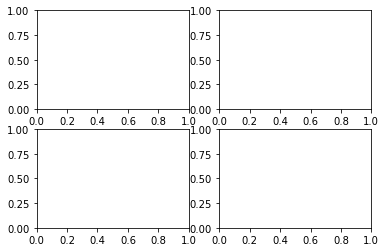

In [17]:
### Plotting ###
fig, axs = plt.subplots(2, 2)

#Plot of Plutonium Mass
for iso in plut_isotopes:
    axs[0, 0].plot(times, get_mass(iso), label=iso)
axs[0, 0].set(xlabel='time (years)', ylabel='Mass (kg)',
    title='Build up of Plutonium Isotopes in 1 percent Fertile Blanket')
axs[0, 0].legend()
axs[0, 0].grid()

#Plot of fission power
axs[1, 0].plot(times, fis_power, label='Total Fission Power')
for iso in fis_isotopes:
    axs[1, 0].plot(times, get_fis_power(iso), label=iso)
axs[1, 0].set(xlabel='time (years)', ylabel='Power (MW)',
    title='Fission Power in 1 percent Fertile Blanket')
axs[1, 0].legend()
axs[1, 0].grid()

#Plot of Uranium mass
axs[0, 1].plot(times, get_mass('U238'), label='U238')
axs[0, 1].set(xlabel='time (years)', ylabel='Mass (kg)',
    title='Mass of U238 in 1 percent Fertile Blanket')
axs[0, 1].grid()

#Plot of fission product masses
for iso in fis_products:
    axs[1, 1].plot(times, get_mass(iso), label=iso)
axs[1, 1].set(xlabel='time (years)', ylabel='Mass (kg)',
    title='Mass of Certain Fission Products in 1 percent Fertile Blanket')
axs[1, 1].legend()
axs[1, 1].grid()

plt.show()